In [197]:
from skimage import morphology as mo
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
from skimage.morphology import skeletonize, medial_axis
from skimage.util import invert
from scipy import ndimage as ndi
import cv2 as cv
from scipy.ndimage import convolve
import yaml
import networkx as nx
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass
from scipy.spatial.distance import cdist
import json

In [198]:
# Definición de kernels para detección de características
S1 = np.array(([0, -1, 0], [1, 1, 1], [-1, 1, -1]), dtype="int")
S2 = np.array(([0, -1, 1], [1, 1, -1], [-1, 1, 0]), dtype="int")
S3 = np.array(([0, -1, 1], [1, 1, -1], [0, -1, 1]), dtype="int")
S4 = np.array(([-1, -1, 1], [-1, 1, -1], [1, -1, 1]), dtype="int")
S1f = np.array(([-1, -1, -1], [1, 1, -1], [-1, -1, -1]), dtype="int")
S2f = np.array(([-1, -1, 1], [-1, 1, -1], [-1, -1, -1]), dtype="int")

def detector(I,S):
    I = I.astype(np.uint8)
    H = I[:,:] *0
    for i in range(4):
        S = np.rot90(S)
        H = H + cv.morphologyEx(I, cv.MORPH_HITMISS, S)
    return H
        

In [199]:
def chebyshev_distance(p1, p2):
    return max(abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))

def separarDT(image, k):
    binary_image = (image > 0).astype(np.uint8)  # Convertir a binario
    labeled, num_features = label(binary_image)  # Etiquetar componentes conectados
    
    pixel_groups = []
    trifurcacion = []
    for i in range(1, num_features + 1):
        pixels = np.column_stack(np.where(labeled == i))  # Extraer píxeles del componente
        merged = False
        
        for group in pixel_groups:
            if any(chebyshev_distance(p, pixels[0]) <= k for p in group):
                group.extend(pixels.tolist())
                merged = True
                break
        
        if not merged:
            pixel_groups.append(pixels.tolist())
   
    new_image = np.zeros_like(image)
    new_image2 = np.zeros_like(image)
    for group in pixel_groups:
        if len(group) > 1:
            centroid = np.round(np.mean(group, axis=0)).astype(int)
            new_image[tuple(centroid)] = 255  # Marcar píxel blanco
        else:
            new_image2[tuple(group[0])] = 255  # Marcar píxel blanco
    
    return new_image, new_image2

In [200]:

def furcaciones(I):
    """
    Recive una imagen _gt y devuelve:
    D: np.array: coordenadas en la imágen de las aristas de difurcacion (conectadas a otras 3 aristas)
    T: np.array: coordenadas en la imágen de las aristas de trifurcaciones (conectadas a otras 4 aristas)
    E: np.array: coordenadas en la imágen de las aristas terminles (solo se conectan a una arista)
    
    """
    I = I/255
    #I = (ski.color.rgb2gray(I* 255)).astype(np.uint8)
    T = skeletonize(I)
    # Supongamos que R, G y B son imágenes en escala de grises con el mismo tamaño
    R0 = detector(T,S1) + detector(T,S2) + detector(T,S3) + detector(T,S4) # Canal Rojo
    G0 = detector(T,S1f) + detector(T,S2f)    # Canal Verde
    B0, R0 = separarDT(R0,4)
    D = np.argwhere(R0 > 0)
    T = np.argwhere(B0 > 0)
    E = np.argwhere(G0 > 0)

    # completa la parte que encuentra I 
    # 
    #
    I = 0  
    return D , T, E 


In [201]:
import numpy as np
from scipy.ndimage import label
from scipy.spatial import KDTree

def agrupar_pixeles(skeleton, D, T, E, X, min_dist=5):
    """
    Agrupa píxeles del esqueleto en segmentos de longitud X y calcula nodos intermedios
    asegurando que no estén demasiado juntos y conectándolos correctamente a nodos especiales.

    Parámetros:
    - skeleton: Imagen binaria del esqueleto.
    - D: Lista de bifurcaciones.
    - T: Lista de trifurcaciones.
    - E: Lista de extremos.
    - X: Número de píxeles por segmento.
    - min_dist: Distancia mínima entre nodos intermedios y especiales.

    Retorna:
    - np.array de nodos intermedios.
    - Lista de conexiones [(nodo1, nodo2)] para mantener la continuidad.
    """

    # Obtener los píxeles del esqueleto
    skeleton_bin = (skeleton > 0).astype(np.uint8)
    
    # Etiquetar componentes conectados
    labeled_skeleton, num_components = label(skeleton_bin)

    nodos_especiales = np.vstack((D, T, E))  # Todos los nodos especiales
    tree_especiales = KDTree(nodos_especiales)  # Para verificar proximidad
    nodos_intermedios = []
    conexiones = []

    kdtree = None  # Para optimizar la búsqueda de vecinos
    nodo_anterior = None  # Para mantener la continuidad

    for label_id in range(1, num_components + 1):
        # Extraer los píxeles de un segmento conectado
        segmento = np.argwhere(labeled_skeleton == label_id)

        # Filtrar píxeles que sean bifurcaciones, extremos o trifurcaciones
        segmento = [tuple(p) for p in segmento if tuple(p) not in nodos_especiales]

        # Agrupar en segmentos de tamaño X
        for i in range(0, len(segmento), X):
            subsegmento = segmento[i:i + X]
            if len(subsegmento) > 0:  # Evitar segmentos vacíos
                promedio = tuple(np.mean(subsegmento, axis=0).astype(int))

                # Verificar si está demasiado cerca de un nodo especial
                dist, idx = tree_especiales.query(promedio)
                if dist < min_dist:
                    # Conectar nodo anterior al nodo especial más cercano
                    if nodo_anterior is not None:
                        conexiones.append((nodo_anterior, tuple(nodos_especiales[idx])))
                    nodo_anterior = tuple(nodos_especiales[idx])  # Actualizar nodo anterior
                    continue  # No agregar este nodo intermedio

                # Si no está cerca de un nodo especial, agregarlo
                if kdtree:
                    dist, _ = kdtree.query(promedio)
                    if dist < min_dist:
                        continue  # Omitir nodos que estén muy cerca de otros intermedios

                nodos_intermedios.append(promedio)
                kdtree = KDTree(nodos_intermedios)  # Actualizar KDTree

                # Conectar al nodo anterior si existe
                if nodo_anterior is not None:
                    conexiones.append((nodo_anterior, promedio))

                nodo_anterior = promedio  # Actualizar nodo anterior

    return np.array(nodos_intermedios), conexiones


In [202]:
def crear_grafo(D, T, E, I, skeleton,conexiones):
    graph = nx.Graph()
    nodes = []
    edges = []
    node_id = 0

    # Convertir coordenadas a tuplas para facilitar la búsqueda
    nodos_fijos = {tuple(coord): node_id for node_id, coord in enumerate(np.vstack((D, T, E)))}

    # Añadir nodos especiales (bifurcaciones, trifurcaciones y extremos)
    for (y, x), id_nodo in nodos_fijos.items():
        tipo = 'bifurcation' if (y, x) in D else 'trifurcation' if (y, x) in T else 'endpoint'
        nodes.append({"id": id_nodo, "x": int(x), "y": int(y), "type": tipo})
        graph.add_node(id_nodo, pos=(x, y), type=tipo)

    # Añadir nodos intermedios
    for y, x in I:
        node_id += 1
        nodes.append({"id": node_id, "x": int(x), "y": int(y), "type": "intermediate"})
        graph.add_node(node_id, pos=(x, y), type='intermediate')

    # Agregar conexiones
    for (y1, x1), (y2, x2) in conexiones:
        id1 = next(n["id"] for n in nodes if (n["y"], n["x"]) == (y1, x1))
        id2 = next(n["id"] for n in nodes if (n["y"], n["x"]) == (y2, x2))
        graph.add_edge(id1, id2)
        edges.append([id1, id2])

    return graph, nodes, edges


In [203]:
# Cargar la imagen
I = plt.imread('database/2_gt.pgm')

# Obtener nodos de bifurcación, trifurcación y extremos
D, T, E = furcaciones(I)

# Obtener el esqueleto de la imagen
skeleton = skeletonize(I / 255)

# Parámetro X: Tamaño del segmento para nodos intermedios
X = 20

# Calcular nodos intermedios agrupados
I,pixeles_nodo = agrupar_pixeles(skeleton, D, E,T, X)

# Crear el grafo
graph, nodes, edges = crear_grafo(D, T, E, I, skeleton, conexiones)


# Guardar la información en JSON
grafo_json = {
    "nodes": nodes,
    "edges": edges
}

with open(f'graph_2_aprox.json', 'w') as f:
    json.dump(grafo_json, f, indent=4)

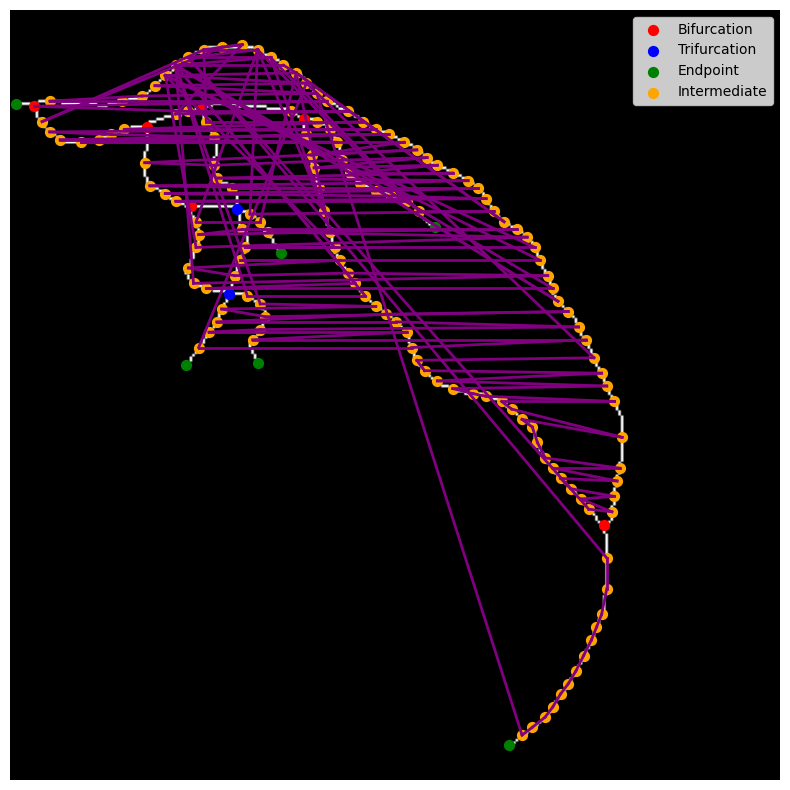

In [204]:
# Visualizar la imagen con los nodos y conexiones superpuestas
plt.figure(figsize=(10, 10))

# Mostrar el esqueleto
plt.imshow(skeleton, cmap='gray')

# Graficar los nodos
for node in nodes:
    x, y = node['x'], node['y']
    if node['type'] == 'bifurcation':
        plt.scatter(x, y, color='red', label='Bifurcation', s=50)  # Nodos de bifurcación en rojo
    elif node['type'] == 'trifurcation':
        plt.scatter(x, y, color='blue', label='Trifurcation', s=50)  # Nodos de trifurcación en azul
    elif node['type'] == 'endpoint':
        plt.scatter(x, y, color='green', label='Endpoint', s=50)  # Nodos extremos en verde
    elif node['type'] == 'intermediate':
        plt.scatter(x, y, color='orange', label='Intermediate', s=50)  # Nodos intermedios en naranja

# Graficar las conexiones (aristas)
for edge in edges:
    id1, id2 = edge
    x1, y1 = graph.nodes[id1]['pos']  # Obtener coordenadas del primer nodo
    x2, y2 = graph.nodes[id2]['pos']  # Obtener coordenadas del segundo nodo
    plt.plot([x1, x2], [y1, y2], color='purple', linewidth=2)  # Dibujar línea entre nodos

# Evitar etiquetas duplicadas en la leyenda
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Desactivar ejes
plt.axis('off')

# Mostrar la imagen
plt.show()